First, I'll install the required packages:

In [156]:
!pip install deap

In [157]:
!pip install multiprocessing

  Using cached multiprocessing-2.6.2.1.tar.gz (108 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [158]:
# graphviz is installed already, but need lib too
!apt install libgraphviz-dev
!pip install pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgraphviz-dev is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [159]:
!pip install gymnasium[classic-control]

In [160]:
!pip install pygame

## Observable CartPole

Now let's continue with the observable CartPole environment:

In [161]:
import numpy
import random
import gymnasium as gym
import operator
import matplotlib.pyplot as plt
import math
from operator import attrgetter
import pygraphviz

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp
import pygame

import multiprocessing

In [162]:
def protectedDiv(left, right):
    try: return truncate(left, 8) / truncate(right, 8)
    except ZeroDivisionError: return 0

def limit(input, minimum, maximum):
    return min(max(input,minimum), maximum)

# Helper function to limit decimal places
def truncate(number, decimals=0):
    if not isinstance(decimals, int):
        raise TypeError("decimal places must be an integer.")
    elif decimals < 0:
        raise ValueError("decimal places has to be 0 or more.")
    elif decimals == 0:
        return math.modf(number)[1]
    factor = 10.0 ** decimals
    return math.modf(number * factor)[1] / factor

def square(input):
    return (input**2)

In [163]:
# Set up primitives and terminals using DEAP syntax
obs_size = 4 # CartPole-v1 has 4 variables in each observation (change for other tasks)
pset = gp.PrimitiveSet("MAIN", obs_size)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(math.sin, 1)
pset.addPrimitive(limit, 3)

In [164]:
env_noviz = gym.make("CartPole-v1")
env_viz = gym.make("CartPole-v1", render_mode="human")

In [165]:
def action_wrapper(action):
    if action < 0:
        return 0 #left force
    else:
        return 1 #right force

In [166]:
# Evaluates the fitness of an individual policy
def evalRL(policy, vizualize=False):
    env = env_viz if vizualize else env_noviz
    num_episode = 1 if vizualize else 20
    # transform expression tree to functional Python code
    get_action = gp.compile(policy, pset)
    fitness = 0
    for x in range(0, num_episode):
        done = False
        truncated = False
        # reset environment and get first observation
        observation = env.reset()
        observation = observation[0]
        episode_reward = 0
        num_steps = 0
        # evaluation episode
        while not (done or truncated):
            # use the expression tree to compute action
            action = get_action(observation[0], observation[1], observation[2], observation[3])
            action = action_wrapper(action)
            try:
                observation, reward, done, truncated, info = env.step(action)
            except:
                return (0,)
            episode_reward += reward
            num_steps += 1
        fitness += episode_reward
    if vizualize:
        env.close()
    return (fitness / num_episode,)

In [167]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genFull, pset=pset, min_=2, max_=3)
toolbox.register("individual", tools.initIterate, creator.Individual,
                 toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evalRL)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [168]:
random.seed(42)
# set to the number of cpu cores available
num_parallel_evals = 4

population_size = 24
num_generations = 100
prob_xover = 0.9
prob_mutate = 0.1

pop = toolbox.population(n=population_size)

# HallOfFame archives the best individuals found so far,
# even if they are deleted from the population.
hof = tools.HallOfFame(1)  # We keep the single best.

# configues what stats we want to track
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)

#setup parallel evaluations
pool = multiprocessing.Pool(processes=num_parallel_evals)
toolbox.register("map", pool.map)

# run the evolutionary algorithm
pop, log = algorithms.eaSimple(
    pop,
    toolbox,
    prob_xover,
    prob_mutate,
    num_generations,
    stats=mstats,
    halloffame=hof,
    verbose=True
)

pool.close()

best_fits = log.chapters["fitness"].select("max")
best_fit = truncate(hof[0].fitness.values[0], 0)

print("Best fitness: " + str(best_fit))
print(hof[0])

   	      	                    fitness                    	                     size                     
   	      	-----------------------------------------------	----------------------------------------------
gen	nevals	avg    	gen	max   	min 	nevals	std    	avg    	gen	max	min	nevals	std   
0  	24    	35.1229	0  	111.85	9.15	24    	29.3204	11.8333	0  	24 	4  	24    	5.8642
1  	22    	41.4812	1  	166.5 	10.6	22    	32.4584	13     	1  	22 	6  	22    	5.60506
2  	24    	53.6292	2  	491.6 	9.2 	24    	95.7208	14     	2  	22 	7  	24    	5.91608
3  	22    	115.84 	3  	500   	9.5 	22    	164.056	15.4167	3  	23 	7  	22    	5.53712
4  	22    	255.775	4  	500   	9.05	22    	212.486	17.0833	4  	26 	6  	22    	4.80379
5  	24    	339.192	5  	500   	19.85	24    	183.77 	17.1667	5  	28 	7  	24    	5.28888
6  	21    	341.525	6  	500   	9.7  	21    	194.377	19.125 	6  	29 	10 	21    	5.02753
7  	22    	405.394	7  	500   	24.15	22    	151.531	20     	7  	29 	14 	22    	3.92641
8  	24    	383.262	8  

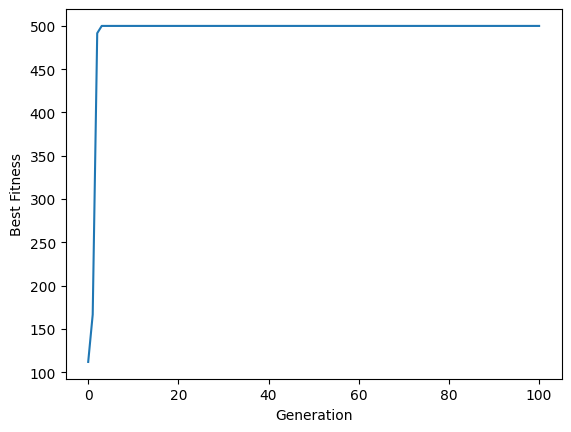

In [169]:
plt.plot(best_fits)
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.show()

In [170]:
evalRL(policy=hof[0], vizualize=True)

(500.0,)

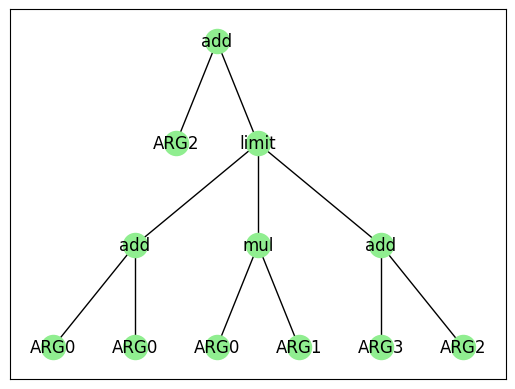

In [171]:
nodes, edges, labels = gp.graph(hof[0])

### Graphviz Section ###
import pygraphviz as pgv

g = pgv.AGraph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)
g.layout(prog="dot")

for i in nodes:
    n = g.get_node(i)
    n.attr["label"] = labels[i]

g.draw("tree.pdf")
import matplotlib.pyplot as plt
import networkx as nx

g = nx.Graph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)
pos = nx.drawing.nx_agraph.graphviz_layout(g, prog="dot")

nx.draw_networkx_nodes(g, pos, node_color="lightgreen")
nx.draw_networkx_edges(g, pos)
nx.draw_networkx_labels(g, pos, labels)
plt.show()

In [172]:
observablepolicy = best_fits

## Partially observable with no memory

In this section, I will try to optimize the policy for the partially observable CartPole with no memory.

In [173]:

def random_constant():
    return  round(numpy.random.uniform(0, 10), 2)



def protectedDiv(left, right):
    try: return truncate(left, 8) / truncate(right, 8)
    except ZeroDivisionError: return 0

def if_then_else(input, output1, output2):
    if input: return output1
    else: return output2

def limit(input, minimum, maximum):
    return min(max(input,minimum), maximum)

# Helper function to limit decimal places
def truncate(number, decimals=0):
    if not isinstance(decimals, int):
        raise TypeError("decimal places must be an integer.")
    elif decimals < 0:
        raise ValueError("decimal places has to be 0 or more.")
    elif decimals == 0:
        return math.modf(number)[1]
    factor = 10.0 ** decimals
    return math.modf(number * factor)[1] / factor

# Step 3: Define GP Primitives
# Set up primitives and terminals using DEAP syntax
obs_size = 2 # CartPole with 2 variables in each observation is considered
pset = gp.PrimitiveSet("MAIN", obs_size)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(limit, 3)
pset.addEphemeralConstant("const", random_constant)  # Random constants0

In [174]:
# Step 4: Define Fitness Function
pygame.init()
env_noviz = gym.make("CartPole-v1")
env_viz = gym.make("CartPole-v1", render_mode="human")

In [175]:
def action_wrapper(action):
    if action < 0:
        return 0 #left force
    else:
        return 1 #right force

In [176]:
# Evaluates the fitness of an individual policy
def evalRL(policy, vizualize=False):
    pygame.init()
    env = env_viz if vizualize else env_noviz
    num_episode = 1 if vizualize else 20
    # transform expression tree to functional Python code
    get_action = gp.compile(policy, pset)
    fitness = 0
    for x in range(0, num_episode):
        done = False
        truncated = False
        # reset environment and get first observation
        observation = env.reset()
        observation = observation[0]
        episode_reward = 0
        num_steps = 0
        # evaluation episode
        while not (done or truncated):
            # use the expression tree to compute action
            action = get_action(observation[0], observation[2])
            action = action_wrapper(action)
            observation, reward, done, truncated, info = env.step(action)
            episode_reward += reward
            num_steps += 1
        fitness += episode_reward
    #if vizualize:
    #    env.close()
    return (fitness / num_episode,)

In [177]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genFull, pset=pset, min_=2, max_=5)
toolbox.register("individual", tools.initIterate, creator.Individual,
                 toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evalRL)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [178]:
random.seed(42)
# set to the number of cpu cores available
num_parallel_evals = 4

population_size = 25
num_generations = 100
prob_xover = 0.8
prob_mutate = 0.2

pop = toolbox.population(n=population_size)

# HallOfFame archives the best individuals found so far,
# even if they are deleted from the population.
hof = tools.HallOfFame(1)  # We keep the single best.

# configues what stats we want to track
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)

#setup parallel evaluations
pool = multiprocessing.Pool(processes=num_parallel_evals)
toolbox.register("map", pool.map)

# run the evolutionary algorithm
pop, log = algorithms.eaSimple(
    pop,
    toolbox,
    prob_xover,
    prob_mutate,
    num_generations,
    stats=mstats,
    halloffame=hof,
    verbose=True
)

pool.close()

best_fits = log.chapters["fitness"].select("max")
best_fit = truncate(hof[0].fitness.values[0], 0)

print("Best fitness: " + str(best_fit))
print(hof[0])

   	      	                    fitness                    	                      size                     
   	      	-----------------------------------------------	-----------------------------------------------
gen	nevals	avg   	gen	max 	min	nevals	std    	avg  	gen	max	min	nevals	std    
0  	25    	17.496	0  	43.4	8.5	25    	12.0207	29.68	0  	74 	7  	25    	23.4993
1  	21    	25.046	1  	46.5	9.35	21    	13.7957	33.04	1  	80 	7  	21    	24.8024
2  	16    	30.154	2  	50.05	9.3 	16    	12.8195	39.4 	2  	82 	6  	16    	23.8713
3  	18    	31.722	3  	50.05	8.7 	18    	13.7147	38.6 	3  	81 	1  	18    	22.4464
4  	17    	36.564	4  	48.2 	8.75	17    	12.423 	41.28	4  	78 	9  	17    	20.3794
5  	24    	32.812	5  	46.2 	9.05	24    	14.2723	38.44	5  	80 	8  	24    	22.1307
6  	23    	30.914	6  	46.55	9.1 	23    	14.1641	41.48	6  	74 	8  	23    	23.3959
7  	21    	36.822	7  	48.05	9.7 	21    	12.1735	44.12	7  	77 	16 	21    	21.1061
8  	21    	36.218	8  	48.35	9.35	21    	13.1301	38.84	8  	84 	

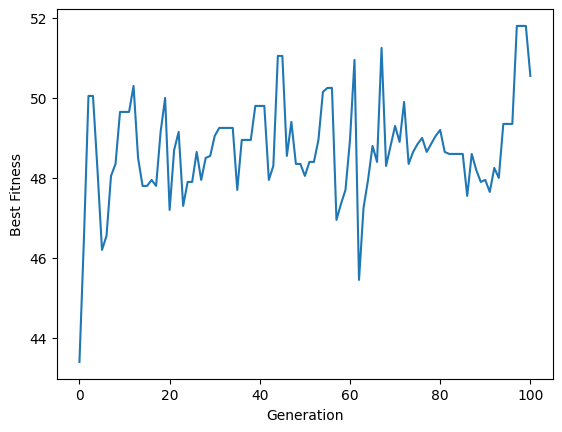

In [179]:
plt.plot(best_fits)
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.show()

In [180]:
# Step 4: Define Fitness Function
pygame.init()
env_noviz = gym.make("CartPole-v1")
env_viz = gym.make("CartPole-v1", render_mode="human")
evalRL(policy=hof[0], vizualize=True)

(29.0,)

Best policy Tree without memory is:

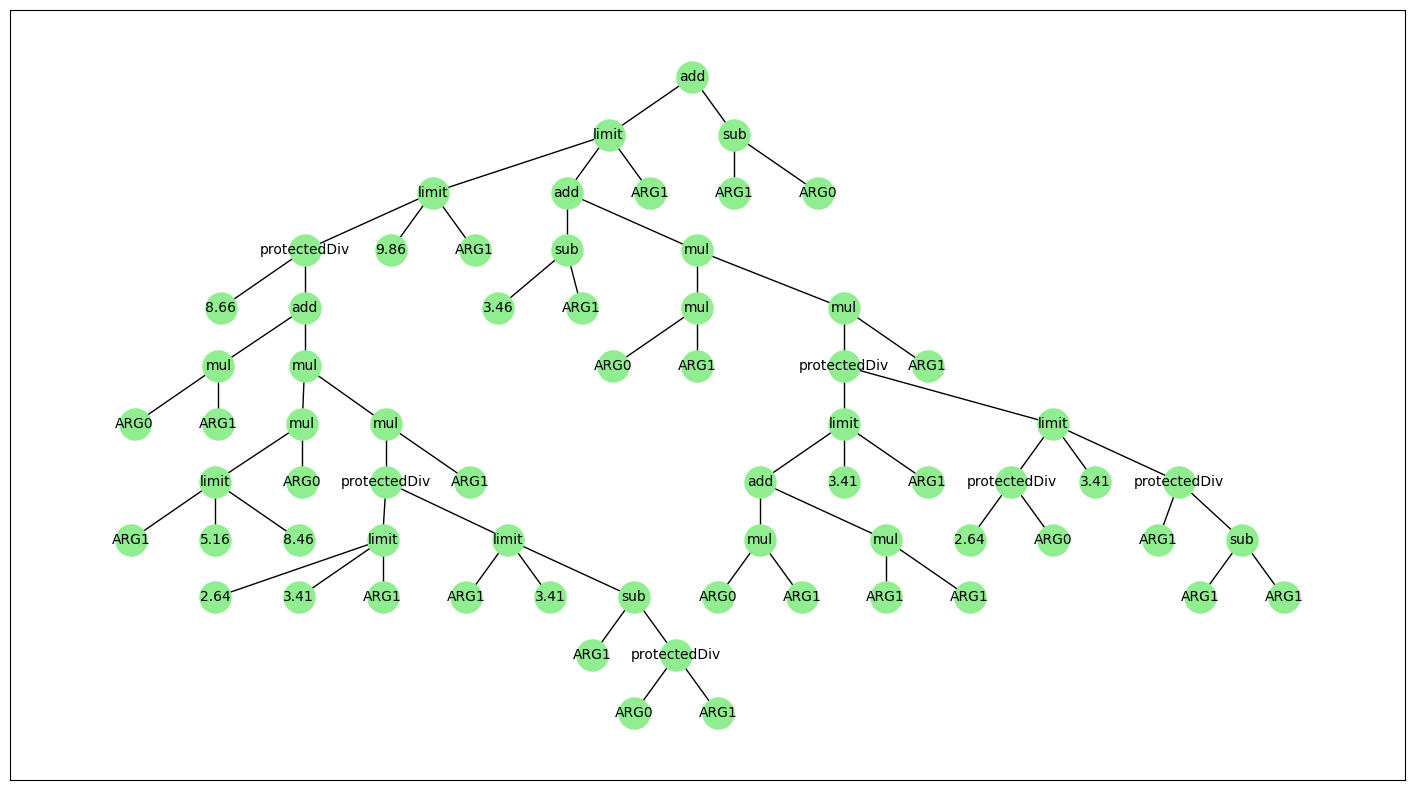

In [181]:
nodes, edges, labels = gp.graph(hof[0])

### Graphviz Section ###
import pygraphviz as pgv

# Create and configure the AGraph for saving as PDF with additional spacing
g = pgv.AGraph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)
g.graph_attr.update(ranksep="1", nodesep="0.5")  # Adjust rank and node separation
g.layout(prog="dot")

# Set labels for each node
for i in nodes:
    n = g.get_node(i)
    n.attr["label"] = labels[i]

g.draw("tree.pdf")

import matplotlib.pyplot as plt
import networkx as nx

# Configure and draw with NetworkX for visualization
g = nx.Graph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)
pos = nx.drawing.nx_agraph.graphviz_layout(g, prog="dot")

plt.figure(figsize=(18, 10))  # Increase figure size to allow more spacing
nx.draw_networkx_nodes(g, pos, node_color="lightgreen", node_size=500)  # Larger node size for visibility
nx.draw_networkx_edges(g, pos)
nx.draw_networkx_labels(g, pos, labels, font_size=10)  # Set font size for clarity
plt.show()


In [182]:
bestfitnomemory = best_fits

## Memory-indexed method

Now let's try to implement the memory-indexed method.

In [183]:
def mem_write(index, value):
    """Store a value in memory at a given index."""
    oldvalue = memory[int(index)%MEMORY_SIZE]
    memory[int(index)%MEMORY_SIZE] = value
    return oldvalue

def mem_read(index):
    """Retrieve a value from memory."""
    return memory[int(index)%MEMORY_SIZE]

def if_pos(val, out1, out2):
    return out1 if val > 0 else out2

In [184]:
MEMORY_SIZE = 10
# Set up primitives and terminals using DEAP syntax
obs_size = 2 # CartPole with 2 variables in each observation is considered
pset = gp.PrimitiveSet("MAIN", obs_size)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(limit, 3)
pset.addPrimitive(if_pos, 3)
pset.addPrimitive(mem_read, 1)  # Memory read
pset.addPrimitive(mem_write, 2)  # Memory write
pset.addPrimitive(math.sin, 1)
pset.addPrimitive(math.cos, 1)
pset.addEphemeralConstant("const", random_constant)  # Random constants0

In [185]:
# Step 4: Define Fitness Function
pygame.init()
env_noviz = gym.make("CartPole-v1")
env_viz = gym.make("CartPole-v1", render_mode="human")

In [186]:
def action_wrapper(action):
    if action < 0:
        return 0 #left force
    else:
        return 1 #right force

In [187]:
# Evaluates the fitness of an individual policy
def evalRL(policy, vizualize=False):
    pygame.init()
    env = env_viz if vizualize else env_noviz
    num_episode = 1 if vizualize else 20
    # transform expression tree to functional code
    get_action = gp.compile(policy, pset)
    fitness = 0
    for x in range(0, num_episode):
        done = False
        truncated = False
        # reset environment and get first observation
        observation = env.reset()
        global memory  # Reset memory at each episode
        memory = numpy.zeros(MEMORY_SIZE)
        observation = observation[0]
        episode_reward = 0
        num_steps = 0
        # evaluation episode
        while not (done or truncated):
            # use the expression tree to compute action
            action = get_action(observation[0], observation[2])
            action = action_wrapper(action)
            observation, reward, done, truncated, info = env.step(action)
            episode_reward += reward
            num_steps += 1
        fitness += episode_reward
    #if vizualize:
    #    env.close()
    return (fitness / num_episode,)

In [188]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genFull, pset=pset, min_=2, max_=5)
toolbox.register("individual", tools.initIterate, creator.Individual,
                 toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evalRL)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [189]:
random.seed(42)
# set to the number of cpu cores available
num_parallel_evals = 4

population_size = 100
num_generations = 100
prob_xover = 0.7
prob_mutate = 0.3

pop = toolbox.population(n=population_size)

# HallOfFame archives the best individuals found so far,
# even if they are deleted from the population.
hof = tools.HallOfFame(1)  # We keep the single best.

# configues what stats we want to track
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)

#setup parallel evaluations
pool = multiprocessing.Pool(processes=num_parallel_evals)
toolbox.register("map", pool.map)

# run the evolutionary algorithm
pop, log = algorithms.eaSimple(
    pop,
    toolbox,
    prob_xover,
    prob_mutate,
    num_generations,
    stats=mstats,
    halloffame=hof,
    verbose=True
)

pool.close()

best_fits = log.chapters["fitness"].select("max")
best_fit = truncate(hof[0].fitness.values[0], 0)

print("Best fitness: " + str(best_fit))
print(hof[0])

   	      	                    fitness                    	                     size                     
   	      	-----------------------------------------------	----------------------------------------------
gen	nevals	avg    	gen	max  	min 	nevals	std    	avg 	gen	max	min	nevals	std   
0  	100   	13.3885	0  	44.15	8.65	100   	8.53061	21.6	0  	113	3  	100   	19.976
1  	84    	19.3515	1  	77.9 	8.7 	84    	13.0138	27.84	1  	115	2  	84    	22.8065
2  	71    	26.504 	2  	79   	9.05	71    	13.669 	26.43	2  	79 	1  	71    	18.7469
3  	81    	32.2505	3  	82.5 	9.2 	81    	13.8455	28.58	3  	80 	2  	81    	17.1086
4  	82    	36.265 	4  	79.45	8.7 	82    	15.4954	27.46	4  	66 	2  	82    	12.9872
5  	84    	34.6605	5  	147.7	8.85	84    	18.8854	26.84	5  	66 	1  	84    	13.4972
6  	88    	41.699 	6  	169.95	8.8 	88    	26.1125	30.42	6  	63 	4  	88    	12.6461
7  	81    	43.142 	7  	175.1 	8.85	81    	33.13  	30.42	7  	70 	3  	81    	14.4922
8  	82    	51.956 	8  	177.65	9.2 	82    	41.3006	31

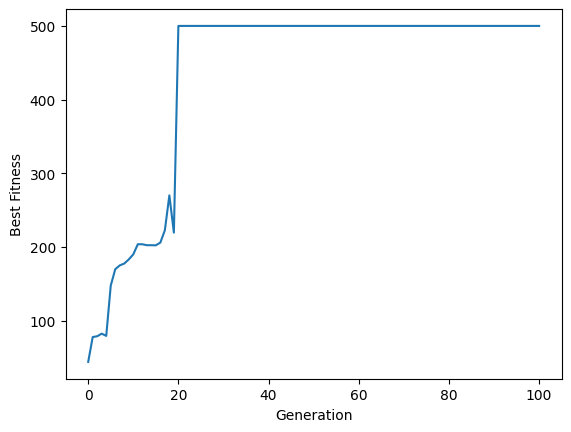

In [190]:
plt.plot(best_fits)
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.show()

In [191]:
# Step 4: Define Fitness Function
pygame.init()
env_noviz = gym.make("CartPole-v1")
env_viz = gym.make("CartPole-v1", render_mode="human")
evalRL(policy=hof[0], vizualize=True)

(500.0,)

Ploting the best policy tree with memory:

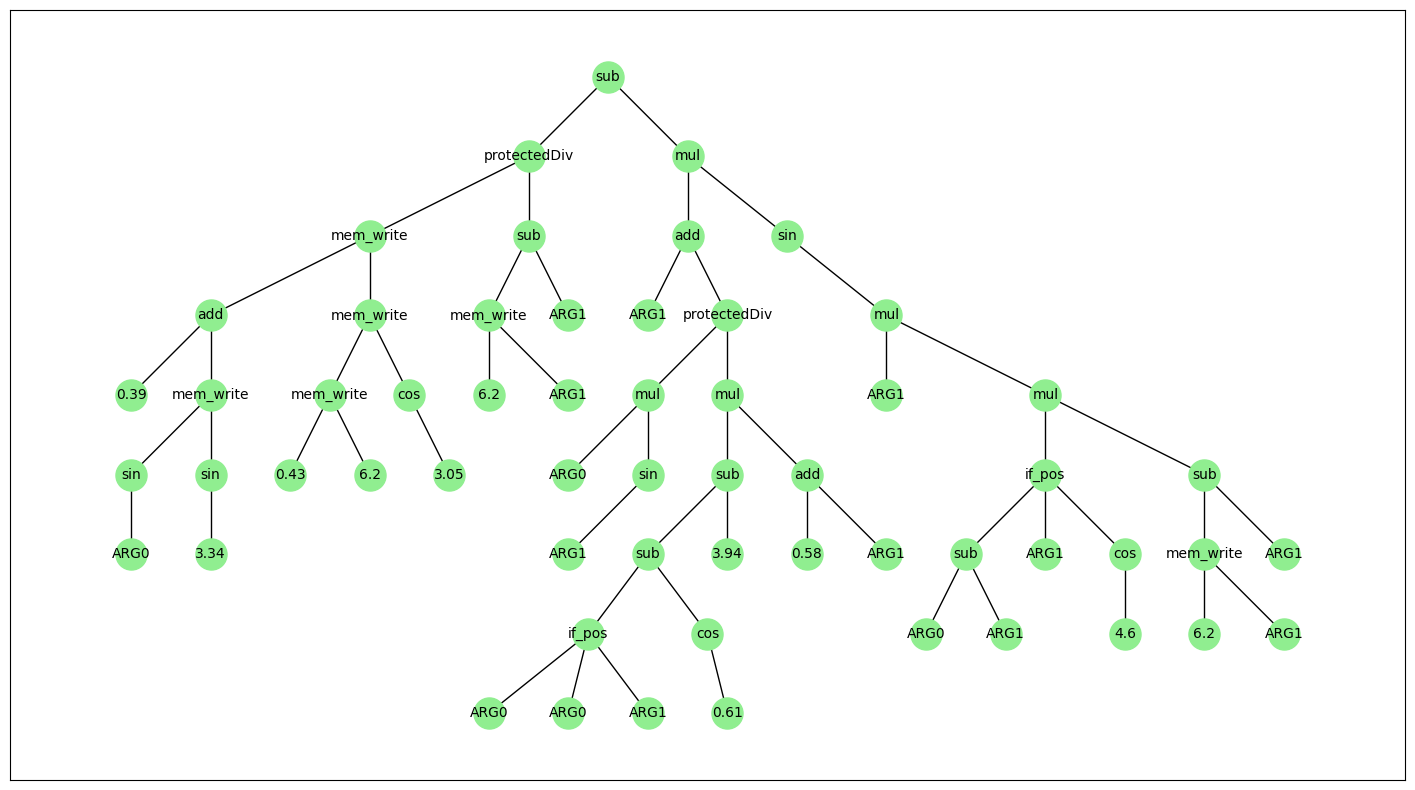

In [192]:
nodes, edges, labels = gp.graph(hof[0])

# Create and configure the AGraph for saving as PDF with additional spacing
g = pgv.AGraph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)
g.graph_attr.update(ranksep="1", nodesep="0.5")  # Adjust rank and node separation
g.layout(prog="dot")

# Set labels for each node
for i in nodes:
    n = g.get_node(i)
    n.attr["label"] = labels[i]

g.draw("tree.pdf")

import matplotlib.pyplot as plt
import networkx as nx

# Configure and draw with NetworkX for visualization
g = nx.Graph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)
pos = nx.drawing.nx_agraph.graphviz_layout(g, prog="dot")

plt.figure(figsize=(18, 10))  # Increase figure size to allow more spacing
nx.draw_networkx_nodes(g, pos, node_color="lightgreen", node_size=500)  # Larger node size for visibility
nx.draw_networkx_edges(g, pos)
nx.draw_networkx_labels(g, pos, labels, font_size=10)  # Set font size for clarity
plt.show()


## Policy Tree Analysis

The evolved policy tree for the **partially observable CartPole problem** have several key mechanisms:

### 1. Conditional Logic (`if_pos` Nodes)

The use of `if_pos` nodes allows the policy to make decisions based on observable inputs like **cart position (ARG0)** and **pole angle (ARG1)**, or memory values. These conditional checks enable the policy to adapt its behavior to different system states.

### 2. Memory Operations (`mem_read` and `mem_write`)

The presence of `mem_read` and `mem_write` nodes shows that the policy leverages **memory** to store and retrieve information across time steps. This ability to "remember" past states or actions helps the policy make more informed decisions in a setting where not all information is observable at every time step.

### 3. Mathematical Operations (Add, Subtract, Multiply, Protected Division)

The policy applies **non-linear transformations** to inputs via operations like `add`, `sub`, `mul`, and `protectedDiv`. These allow the policy to compute more sophisticated control signals. The use of protected division ensures numerical stability, preventing errors from division by zero.

### 4. Trigonometric Functions (`sin` and `cos`)

Functions like `sin` and `cos` introduce **oscillatory behavior**, enabling smooth, periodic adjustments to control the cart and pole. This helps the policy apply continuous corrections, aiding in system stabilization.

### 5. Constants

Fixed **ephemeral constants** (e.g., 4.62, 1.49) are used to **scale** and **shift** inputs or intermediate values. These constants help the policy define critical thresholds where specific actions are required, such as applying stronger corrections when the cart or pole deviates significantly.

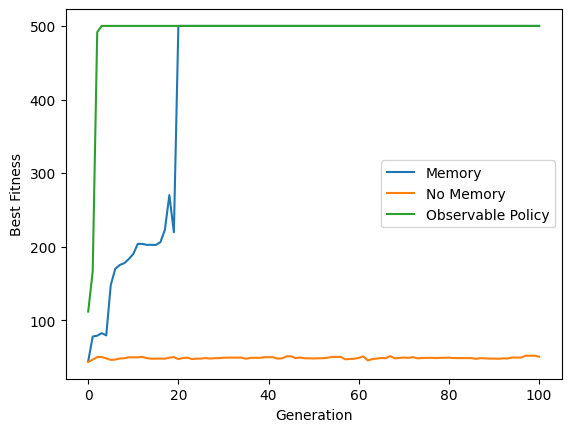

In [193]:
plt.plot(best_fits,label='Memory')
plt.plot(bestfitnomemory,label='No Memory')
plt.plot(observablepolicy,label='Observable Policy')
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.legend()
plt.show()

## Conclusion

### Indexed Memory's Impact

The **indexed memory policy** outperforms the **no-memory policy**, achieving higher fitness in **partially observable environments** by leveraging stored information for better decision-making.

### Comparison with Fully Observable Policy

Though not fully observable, the indexed memory policy achieves near-parity with the **fully observable policy**, reaching comparable peak fitness by the 20th generation, effectively bridging the observability gap.

### No-Memory Policy Limitations

The **no-memory policy** shows minimal improvement, highlighting the inadequacy of stateless approaches in environments where **past information** is critical for informed decisions.

### Convergence

Both **indexed memory** and **fully observable policies** converge to optimal fitness by the 20th generation, demonstrating memory's role in accelerating learning.

## Approach

The GP used a **primitive set** of mathematical operations, conditionals, trigonometric functions, and memory primitives (`mem_read`, `mem_write`), enabling the evolution of both **reactive** and **memory-based** strategies.

## Challenges

1. **Partial Observability**: Missing velocity data required effective memory use, complicating policy evolution.
2. **Convergence Speed**: Early difficulty in evolving memory strategies necessitated adjusting **mutation rates** and **selection criteria** to avoid premature convergence.
3. **Interpretability**: The **complexity** of evolved trees, combining memory and conditionals, makes them hard to interpret.

## Open Questions

1. **Memory Efficiency**: Could simpler strategies use memory more efficiently?
2. **Robustness**: Can policies generalize to environments with different physics or variations of CartPole?
3. **Tree Interpretation**: Understanding memory's role in evolved trees remains challenging due to their nested structure.